## Importing Libraries

In [28]:
import numpy as np
import pandas as pd

import os
import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [29]:
import warnings
warnings.filterwarnings('ignore')

## Paths for data.

In [30]:
ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema = "/kaggle/input/cremad/AudioWAV/"
tess = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

## Data Preparation

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [31]:
os.listdir(ravdess)

['Actor_02',
 'Actor_17',
 'Actor_05',
 'Actor_16',
 'Actor_21',
 'Actor_01',
 'Actor_11',
 'Actor_20',
 'Actor_08',
 'Actor_15',
 'Actor_06',
 'Actor_12',
 'Actor_23',
 'Actor_24',
 'Actor_22',
 'Actor_04',
 'Actor_19',
 'Actor_10',
 'Actor_09',
 'Actor_14',
 'Actor_03',
 'Actor_13',
 'Actor_18',
 'Actor_07']

In [32]:
ravdess_dir = os.listdir(ravdess)

file_emotion = []
file_path = []

for dir in ravdess_dir:
    actor = os.listdir(ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = file.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + '/' + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])

path_df = pd.DataFrame( file_path, columns = ['Path'])

ravdees_df = pd.concat([emotion_df, path_df], axis=1)

ravdees_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [33]:
ravdees_df.head(5)

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [34]:
print(ravdees_df['Path'].iloc[0])

/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24//Actor_02/03-01-08-01-01-01-02.wav


In [35]:
print(ravdees_df.Emotions.value_counts())

Emotions
surprise    192
disgust     192
fear        192
sad         192
happy       192
calm        192
angry       192
neutral      96
Name: count, dtype: int64


## <center>2. Crema DataFrame</center>

In [36]:
crema_dir = os.listdir(crema)

In [37]:
file_emotion = []
file_path = []

for file in crema_dir:
    file_path.append(crema + '/' + file)
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns = ['Emotions'])

path_df = pd.DataFrame(file_path, columns = ['Path'])

crema_df = pd.concat([emotion_df, path_df], axis = 1)


In [38]:
crema_df.head(5)

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV//1028_TSI_DIS_XX...
1,happy,/kaggle/input/cremad/AudioWAV//1075_IEO_HAP_LO...
2,happy,/kaggle/input/cremad/AudioWAV//1084_ITS_HAP_XX...
3,disgust,/kaggle/input/cremad/AudioWAV//1067_IWW_DIS_XX...
4,disgust,/kaggle/input/cremad/AudioWAV//1066_TIE_DIS_XX...


In [39]:
print(crema_df['Path'].iloc[0])


/kaggle/input/cremad/AudioWAV//1028_TSI_DIS_XX.wav


In [40]:
print(crema_df.Emotions.value_counts())

Emotions
disgust    1271
happy      1271
sad        1271
fear       1271
angry      1271
neutral    1087
Name: count, dtype: int64


## Tess dataset

In [41]:
os.listdir(tess)

['YAF_fear',
 'OAF_angry',
 'OAF_Fear',
 'OAF_disgust',
 'OAF_neutral',
 'YAF_angry',
 'OAF_Sad',
 'YAF_disgust',
 'YAF_neutral',
 'OAF_Pleasant_surprise',
 'YAF_happy',
 'OAF_happy',
 'YAF_sad',
 'YAF_pleasant_surprised']

In [42]:
tess_dir = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_dir:
    directories = os.listdir(tess +'/'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
tess_df = pd.concat([emotion_df, path_df], axis=1)


In [43]:
tess_df.head(5)

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [44]:
print(tess_df['Path'].iloc[0])


/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data//YAF_fear/YAF_home_fear.wav


In [45]:
print(tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


## SAVEE

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'


In [46]:
os.listdir(savee)

['JE_h09.wav',
 'KL_f12.wav',
 'DC_h03.wav',
 'DC_d04.wav',
 'KL_a14.wav',
 'JE_f01.wav',
 'KL_h15.wav',
 'JK_su02.wav',
 'JK_a06.wav',
 'DC_n01.wav',
 'DC_f01.wav',
 'JK_n22.wav',
 'KL_a10.wav',
 'JE_n08.wav',
 'KL_sa13.wav',
 'DC_a12.wav',
 'JE_f07.wav',
 'JE_d05.wav',
 'KL_d09.wav',
 'DC_n30.wav',
 'KL_h05.wav',
 'JE_f11.wav',
 'JE_d08.wav',
 'JE_d04.wav',
 'KL_h09.wav',
 'JE_f06.wav',
 'DC_a15.wav',
 'KL_a05.wav',
 'KL_d01.wav',
 'JK_sa06.wav',
 'KL_n20.wav',
 'JE_n17.wav',
 'KL_n12.wav',
 'DC_sa10.wav',
 'JK_n01.wav',
 'DC_h13.wav',
 'KL_su05.wav',
 'KL_n24.wav',
 'JE_n05.wav',
 'KL_sa06.wav',
 'KL_f02.wav',
 'JE_sa12.wav',
 'DC_h05.wav',
 'DC_f02.wav',
 'JK_d12.wav',
 'JE_d03.wav',
 'JE_a06.wav',
 'KL_su12.wav',
 'JE_n23.wav',
 'DC_sa15.wav',
 'DC_f07.wav',
 'DC_h15.wav',
 'JK_su07.wav',
 'DC_sa09.wav',
 'KL_d12.wav',
 'DC_sa06.wav',
 'JE_sa03.wav',
 'JE_sa13.wav',
 'KL_su13.wav',
 'KL_sa01.wav',
 'DC_h06.wav',
 'DC_su15.wav',
 'DC_a03.wav',
 'JK_d11.wav',
 'KL_n27.wav',
 'JE_a04

In [47]:
savee_dir = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_dir:
    file_path.append(savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis=1)

In [48]:
savee_df

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...
...,...,...
475,surprise,/kaggle/input/surrey-audiovisual-expressed-emo...
476,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
477,neutral,/kaggle/input/surrey-audiovisual-expressed-emo...
478,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [49]:
print(savee_df['Path'].iloc[0])

/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL//JE_h09.wav


In [50]:
print(savee_df.Emotions.value_counts())

Emotions
neutral     120
fear         60
happy        60
disgust      60
angry        60
surprise     60
sad          60
Name: count, dtype: int64


## Dataframe using all the 4 dataframes

In [51]:
data_path = pd.concat([ravdees_df, crema_df, tess_df, savee_df], axis = 0)

In [52]:
data_path.to_csv("data_path.csv", index = False )

In [53]:
data_path.head(5)

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [54]:
print(data_path.Emotions.value_counts())

Emotions
fear        1923
disgust     1923
happy       1923
sad         1923
angry       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64


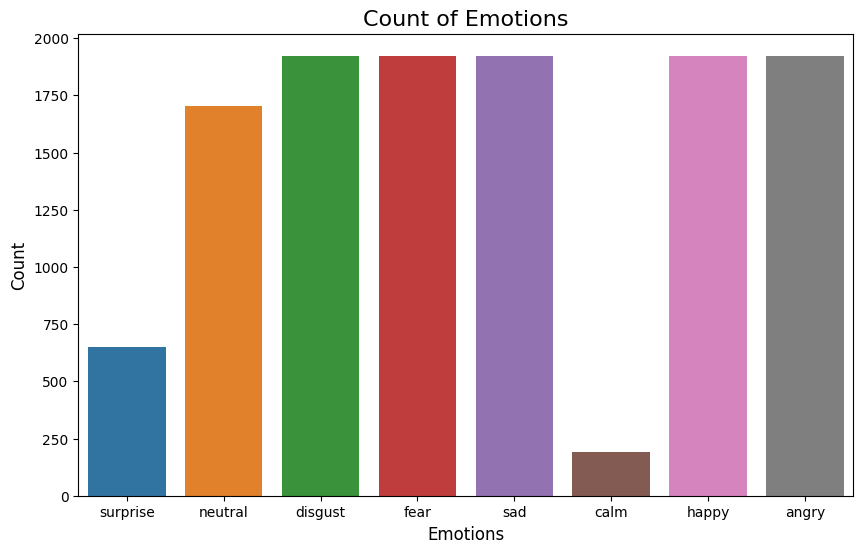

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_path)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()


In [56]:
data_path.shape

(12162, 2)

In [57]:
data,sr = librosa.load(file_path[0])
sr

22050

## Data Argumentation

In [58]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Normal Audio

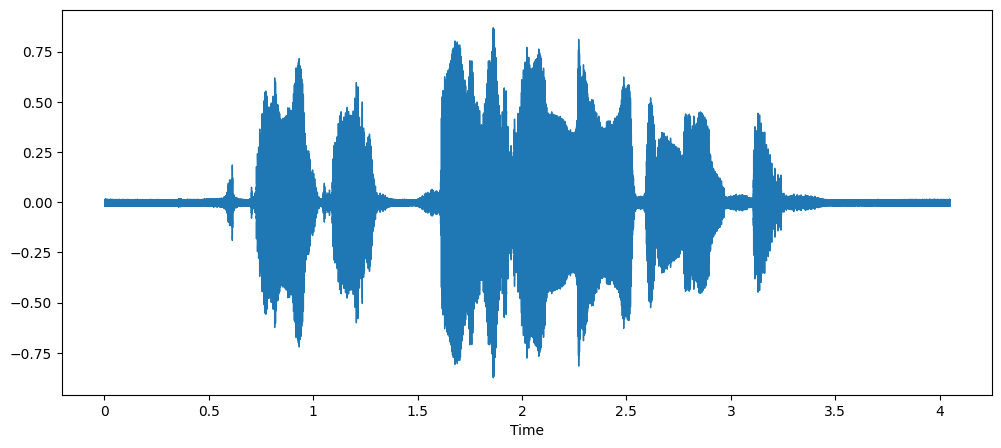

In [59]:
plt.figure(figsize= (12,5))
librosa.display.waveshow(y = data , sr = sr)
ipd.Audio(data, rate = sr)

# Audio with Noise


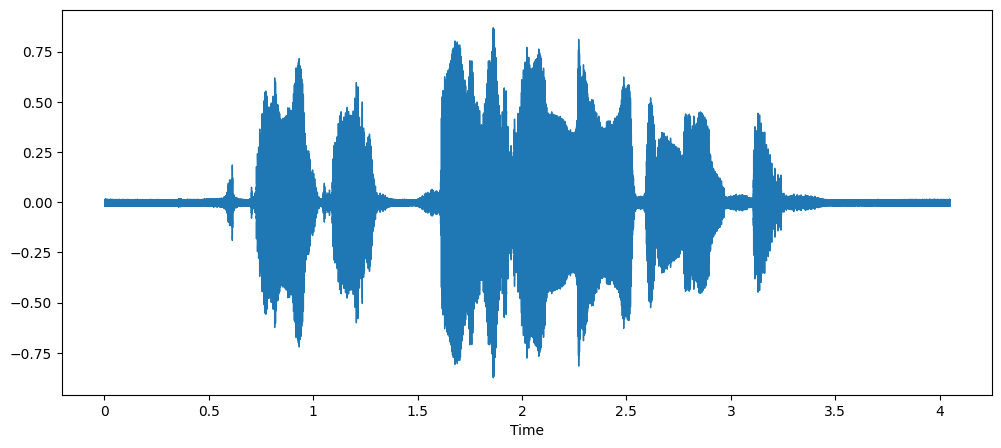

In [60]:
x= noise(data)
plt.figure(figsize = (12,5))
librosa.display.waveshow(y = data , sr = sr)
ipd.Audio(x, rate = sr)

# Streched Audio

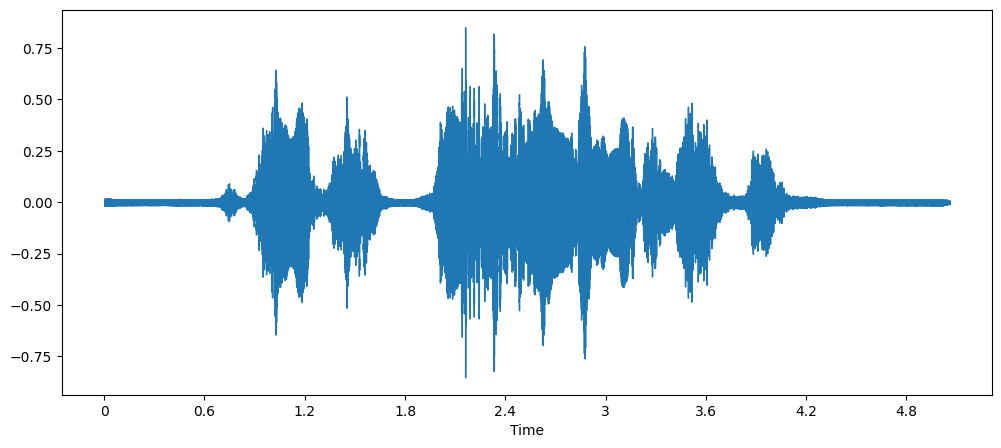

In [61]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

#Shifted audio


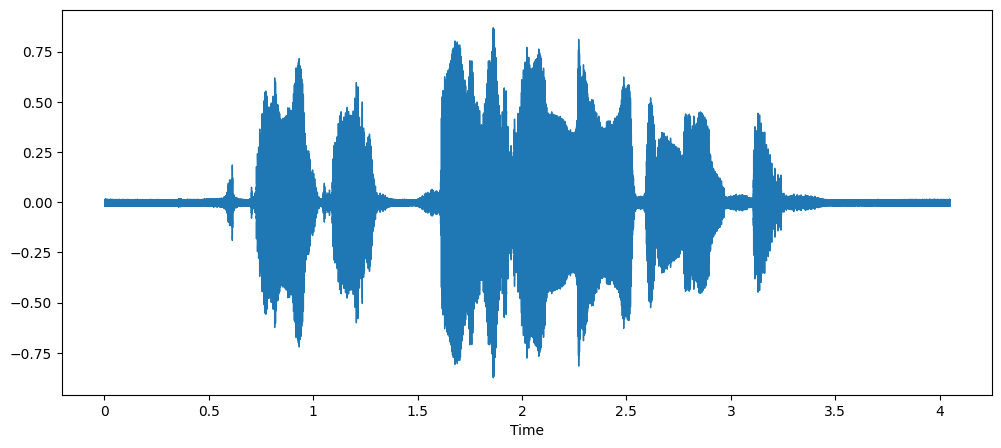

In [62]:
x = shift(data)
plt.figure(figsize = (12,5))
librosa.display.waveshow(y = data , sr = sr)
ipd.Audio(x, rate = sr)

#Audio with pitch

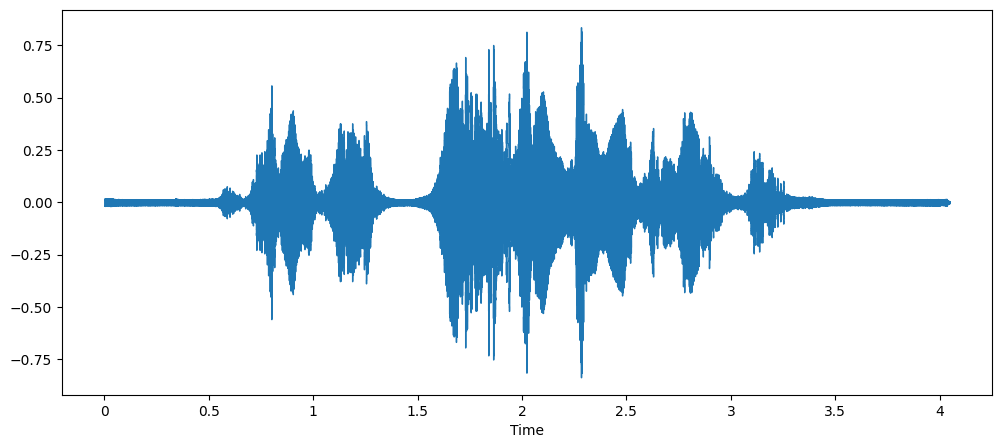

In [63]:
x = pitch(data, sr, pitch_factor=0.7)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

## Feature Extraction

In [64]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_lenght = 2048, hop_length = 512, flatten:bool = True):
  mfcc = librosa.feature.mfcc(y = data,sr = sr)
  return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

In [65]:
def extract_feature(data, sr = 22050, frame_length = 2048, hop_length = 512):
  result = np.array([])
  zcr_result = zcr(data, frame_length, hop_length)
  rmse_result = rmse(data, frame_length, hop_length)
  mfcc_result = mfcc(data, sr, frame_length, hop_length)

  result = np.hstack([zcr_result, rmse_result, mfcc_result])
  return result

In [66]:
def get_features(path, duration = 2.5, offset = 0.6):
  data, sr = librosa.load(path, duration = duration, offset = offset)
  aud = extract_feature(data)
  audio = np.array(aud)

  noised_audio = noise(data)
  aud2 = extract_feature(noised_audio)
  audio = np.vstack((audio,aud2))

  pitched_audio = pitch(data, sr)
  aud3 = extract_feature(pitched_audio)
  audio = np.vstack((audio, aud3))

  pitched_noised_audio = noise(pitched_audio)
  aud4 = extract_feature(pitched_noised_audio)
  audio = np.vstack((audio, aud4))

  return audio


In [67]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


## Get Feature

In [94]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

In [69]:
len(X), len(Y), data_path.Path.shape

(228, 228, (12162,))

## Saving Feature

In [70]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.343750,0.479492,0.573730,0.458008,0.375488,0.301758,0.269043,0.255371,0.251465,0.251953,...,-1.517690,-1.716483,-1.599310,-1.234609,-0.693198,-0.038982,0.675206,1.405603,2.112303,surprise
1,0.261230,0.376953,0.498535,0.494629,0.493164,0.505859,0.509766,0.506348,0.503906,0.494141,...,-1.774359,-0.775590,7.739936,4.371734,0.329158,3.275846,-0.667625,1.369942,-3.580584,surprise
2,0.304199,0.427246,0.540039,0.471191,0.387207,0.333008,0.282227,0.259277,0.258789,0.252930,...,0.518303,0.838663,1.308733,1.855111,2.405192,2.896439,3.283493,3.541682,3.667480,surprise
3,0.243652,0.360840,0.484375,0.488770,0.491211,0.499023,0.488770,0.473145,0.474121,0.471191,...,-1.447073,-6.873628,1.260916,4.262689,-1.052570,0.670687,5.530921,-1.685636,-1.228414,surprise
4,0.437500,0.659668,0.862305,0.878906,0.865234,0.847168,0.845703,0.827637,0.835938,0.667969,...,2.586417,2.746852,2.223276,0.986916,-0.730695,-2.530884,-4.002834,-4.849372,-4.929744,neutral


In [71]:
Emotions = Emotions.fillna(0)

In [72]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [73]:
import numpy as np
import pandas as pd

import os
import sys

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [74]:
Emotions = pd.read_csv('/kaggle/input/emotions/emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.090332,0.136719,0.152344,0.154297,0.120117,0.134766,0.165527,0.193848,0.208496,0.162109,...,4.043136,5.765306,6.346148,5.203500,4.668551,4.742602,2.093227,-4.006017,-9.263257,calm
1,0.252441,0.371094,0.483887,0.481445,0.480469,0.486328,0.508301,0.513184,0.511719,0.512695,...,-2.986572,-2.788266,0.661218,-1.169518,-0.952499,-1.781004,-7.027017,-3.942681,-0.463803,calm
2,0.063965,0.090820,0.101074,0.114746,0.104492,0.154297,0.210449,0.244629,0.226562,0.177246,...,2.500613,4.326787,4.353564,2.234883,0.389981,0.115879,-0.630774,-3.899069,-8.108342,calm
3,0.237305,0.359863,0.487305,0.487305,0.486328,0.478027,0.472168,0.476074,0.484375,0.505371,...,-0.511819,-0.638016,-0.997156,-1.401101,2.070604,0.786888,-3.810704,-2.698174,3.201873,calm
4,0.065918,0.099609,0.159668,0.166504,0.192871,0.197266,0.176758,0.169922,0.160645,0.183105,...,-2.686041,12.111397,7.391188,2.090285,16.099852,18.863033,2.468784,13.105180,10.581881,happy


In [75]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [76]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48728, 2377)

## Data Preparation

In [77]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [78]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [79]:
X.shape

(48728, 2376)

In [80]:
Y.shape

(48728, 8)

In [81]:
##Data preparation

In [82]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)

In [83]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38982, 2376), (38982, 8), (9746, 2376), (9746, 8))

In [84]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [85]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [86]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38982, 2376), (38982, 8), (9746, 2376), (9746, 8))

In [87]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

##Applying early stopping for all models

In [88]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint('/kaggle/working/best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)


## CNN Model

In [89]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)

In [90]:
print("Shape of x_testcnn:", x_traincnn.shape)

Shape of x_testcnn: (38982, 2376, 1)


In [91]:
print("Shape of x_testcnn:", x_testcnn.shape)

Shape of x_testcnn: (9746, 2376, 1)


In [92]:
import tensorflow.keras.layers as L
import tensorflow as tf

input_shape = (X_train.shape[1],1)
model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=input_shape),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 2376, 512)      │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2376, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1188, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1188, 512)      │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1188, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 594, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 594, 256)       │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 594, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 297, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 297, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 297, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 149, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 149, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 149, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,915,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,10

 Total params: 7,193,736 (27.44 MB)

 Trainable params: 7,189,384 (27.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [93]:
history = model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

In [95]:
model.save("speech_emotion_recognition.h5")

In [96]:
model_history= "/kaggle/input/result/speech_emotion_recognition.h5"

In [97]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(model_history)

# Assuming x_testcnn and y_test are your test data
# Evaluate the model on test data
loss, accuracy = model.evaluate(x_testcnn, y_test)
print("Accuracy of the model on test data:", accuracy)


305/305 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9843 - loss: 0.0689
Accuracy of the model on test data: 0.9816334843635559


Evalutation

Saving Best Model

In [98]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json

# Serialize model architecture to JSON
model_json = model.to_json()
with open("/kaggle/working/CNN_model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("/kaggle/working/CNN_model_weights.weights.h5")
print("Saved model to disk")


Saved model to disk


In [99]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/input/result/results/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/input/result/results/best_model1_weights.keras")
print("Loaded model from disk")

Loaded model from disk


Saving and Loading our Stnadrad Scaler and encoder

In [100]:
import pickle

# Saving scaler
with open('/kaggle/working/scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('/kaggle/input/result/results/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('/kaggle/working/encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('/kaggle/input/result/results/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")


Done


## Test script

In [101]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/input/result/results/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/input/result/results/best_model1_weights.keras")
print("Loaded model from disk")

Loaded model from disk


In [102]:
import pickle

with open('/kaggle/input/result/results/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('/kaggle/input/result/results/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")   

Done


In [103]:
import librosa
import numpy as np

def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y =data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y = data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [104]:
def get_predict_feat(path):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)
    result = np.array(res)
    # Dynamically adjust the reshape operation based on the actual size of extracted features
    result = np.reshape(result, newshape=(1, -1))
    i_result = scaler2.transform(result)
    final_result = np.expand_dims(i_result, axis=2)
    
    return final_result


In [105]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0]) 

In [106]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_05/03-01-03-02-01-02-05.wav") # Happy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
happy


--

In [107]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_a01.wav") # Angry

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
angry


In [108]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_03/03-01-02-01-01-01-03.wav") # Calm

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
calm


In [109]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_d15.wav") # Disgust

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
disgust


In [110]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_f08.wav") # Fear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
fear


In [111]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_n07.wav") # Neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
neutral


In [112]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_sa05.wav") # Sad

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
sad


In [113]:
prediction("/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/DC_su07.wav") # Surprise

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
surprise
